<a href="https://colab.research.google.com/github/KrupaMistry18/efficient-llm-sharding/blob/main/heterollm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch, platform, sys, subprocess, os
print("Python:", sys.version.split()[0], "| Torch:", torch.__version__, "| CUDA:", torch.version.cuda)
print("GPU available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))
else:
    print("No GPU? In Colab: Runtime → Change runtime type → Hardware accelerator = GPU")


Python: 3.12.12 | Torch: 2.8.0+cu126 | CUDA: 12.6
GPU available: True
GPU name: Tesla T4


In [ ]:
!pip -q install transformers datasets accelerate matplotlib rich tabulate
# Torch is preinstalled on Colab; we don’t need DeepSpeed/FairScale for this prototype.


In [ ]:
import os, pathlib
for p in ["src", "scripts", "results", "data", "notebooks"]:
    os.makedirs(p, exist_ok=True)
open("src/__init__.py","w").close()
open("scripts/__init__.py","w").close()
print("Folders ready.")


Folders ready.


In [ ]:
%%writefile src/model_loader.py
from transformers import AutoModelForCausalLM

def load_gpt2_small():
    # Downloads the first time; cached afterwards
    model = AutoModelForCausalLM.from_pretrained("gpt2")
    return model


Writing src/model_loader.py


In [ ]:
%%writefile src/mapping.py
from typing import List, Dict

def uniform_mapping(n_blocks: int, devices: List[str]) -> Dict[int, str]:
    """Evenly assign blocks across devices in order."""
    assert len(devices) >= 1
    if len(devices) == 1:
        return {i: devices[0] for i in range(n_blocks)}
    per = n_blocks // len(devices)
    rem = n_blocks % len(devices)
    mapping = {}
    idx = 0
    for d_i, d in enumerate(devices):
        take = per + (1 if d_i < rem else 0)
        for _ in range(take):
            mapping[idx] = d
            idx += 1
    return mapping

def hetero_mapping_by_speed(n_blocks: int, devices: List[str], rel_speed: List[float]) -> Dict[int, str]:
    """Assign blocks proportional to device relative speeds, e.g., rel_speed=[2.0, 1.0]."""
    assert len(devices) == len(rel_speed) and len(devices) >= 1
    total = sum(rel_speed)
    target = [round(n_blocks * (s / total)) for s in rel_speed]

    # adjust rounding so sum == n_blocks
    diff = n_blocks - sum(target)
    order = sorted(range(len(devices)), key=lambda i: rel_speed[i], reverse=True)
    k = 0
    while diff != 0:
        i = order[k % len(order)]
        target[i] += 1 if diff > 0 else -1
        diff += -1 if diff > 0 else 1
        k += 1

    mapping = {}
    idx = 0
    for i, d in enumerate(devices):
        for _ in range(target[i]):
            mapping[idx] = d
            idx += 1
    return mapping

def mapping_by_costs(costs: List[float], devices: List[str], rel_speed: List[float]) -> Dict[int, str]:
    """
    Assign blocks using measured per-block costs.
    Target device cost share is proportional to rel_speed.
    Greedy: fill fastest device up to its target first.
    """
    assert len(devices) == len(rel_speed) >= 1
    n = len(costs)
    total_cost = sum(costs)
    speed_sum = sum(rel_speed)
    targets = [total_cost * (s / speed_sum) for s in rel_speed]

    order = sorted(range(len(devices)), key=lambda i: rel_speed[i], reverse=True)
    mapping = {}
    used = [False] * n

    for di in order:
        cap = targets[di]
        cur = 0.0
        for bi in sorted(range(n), key=lambda j: costs[j], reverse=True):
            if used[bi]:
                continue
            if cur + costs[bi] <= cap or di == order[-1]:  # last device gets the rest
                mapping[bi] = devices[di]
                used[bi] = True
                cur += costs[bi]

    # any unassigned -> slowest
    slowest = order[-1]
    for bi in range(n):
        if bi not in mapping:
            mapping[bi] = devices[slowest]

    return {i: mapping[i] for i in range(n)}


Writing src/mapping.py


In [ ]:
%%writefile src/profiling.py
import time, torch

@torch.no_grad()
def profile_block_forward_times(model, seq_len=256, batch_size=4, iters=3, device="cpu"):
    """
    Returns a list of per-block forward times (seconds) measured on `device`.
    Uses synthetic inputs so it’s fast and self-contained.
    """
    model.eval().to(device)

    vocab = model.config.vocab_size
    input_ids = torch.randint(0, vocab, (batch_size, seq_len), device=device)
    attn = torch.ones_like(input_ids, dtype=torch.bool)[:, None, None, :]  # [B,1,1,S] bool

    pos = torch.arange(0, seq_len, device=device).unsqueeze(0)
    hs = model.transformer.wte(input_ids) + model.transformer.wpe(pos)

    # warmup a couple small blocks
    for _ in range(1):
        tmp = hs
        for blk in model.transformer.h[:2]:
            tmp = blk(tmp, attention_mask=attn)[0]

    times = []
    for blk in model.transformer.h:
        tmp = hs.clone()
        t0 = time.time()
        for _ in range(iters):
            tmp = blk(tmp, attention_mask=attn)[0]
        t1 = time.time()
        times.append((t1 - t0) / iters)

    return times


Writing src/profiling.py


In [ ]:
%%writefile src/sharded_module.py
import torch
from torch import nn
from typing import Dict

class GPT2Sharded(nn.Module):
    """
    Minimal sharder for GPT-2: places specified transformer blocks on target devices
    and routes hidden states across them.
    """
    def __init__(self, model: nn.Module, block_to_device: Dict[int, str]):
        super().__init__()
        self.model = model
        self.block_to_device = dict(block_to_device)

        # Start on block 0's device
        first_dev = torch.device(self.block_to_device[0])

        # Keep tied weights on the SAME device (wte <-> lm_head), and ln_f with them
        self.model.transformer.wte.to(first_dev)
        self.model.transformer.wpe.to(first_dev)
        self.model.transformer.ln_f.to(first_dev)
        self.model.lm_head.to(first_dev)

        # Place transformer blocks where requested
        for i, blk in enumerate(self.model.transformer.h):
            blk.to(torch.device(self.block_to_device[i]))

    def forward(self, input_ids, attention_mask=None):
        dev0 = torch.device(self.block_to_device[0])

        # Embeddings on dev0
        input_ids = input_ids.to(dev0)
        pos = torch.arange(0, input_ids.shape[1], device=dev0).unsqueeze(0)
        hidden_states = self.model.transformer.wte(input_ids) + self.model.transformer.wpe(pos)

        # Key-padding mask: [B,1,1,S], bool
        attn_expanded = None
        if attention_mask is not None:
            attn_expanded = attention_mask
            if attn_expanded.dtype is not torch.bool:
                attn_expanded = attn_expanded != 0
            attn_expanded = attn_expanded.to(dev0)[:, None, None, :]

        # Route through blocks
        for i, blk in enumerate(self.model.transformer.h):
            blk_dev = torch.device(self.block_to_device[i])
            if hidden_states.device != blk_dev:
                hidden_states = hidden_states.to(blk_dev)
            am = attn_expanded.to(blk_dev) if attn_expanded is not None else None
            hidden_states = blk(hidden_states, attention_mask=am)[0]

        # Move back to dev0 for ln_f + lm_head
        if hidden_states.device != dev0:
            hidden_states = hidden_states.to(dev0)
        logits = self.model.lm_head(self.model.transformer.ln_f(hidden_states))
        return logits


Writing src/sharded_module.py


In [ ]:
%%writefile src/train_eval.py
import time, torch
from torch.utils.data import TensorDataset, DataLoader
from transformers import AutoTokenizer
from .model_loader import load_gpt2_small
from .sharded_module import GPT2Sharded
from .mapping import uniform_mapping, hetero_mapping_by_speed, mapping_by_costs
from .profiling import profile_block_forward_times

def detect_devices():
    """
    On Colab, prefer single-device emulation to remove transfer noise.
    If multiple CUDA GPUs exist, we can use two; otherwise we emulate both shards on cuda:0.
    """
    if torch.cuda.is_available():
        n = torch.cuda.device_count()
        if n >= 2:
            return [f"cuda:0", f"cuda:1"]
        return ["cuda:0"]
    return ["cpu"]

@torch.no_grad()
def benchmark(mode: str = "both", samples: int = 256, seq_len: int = 256, batch_size: int = 4, rel_speed=(2.0, 1.0)):
    tok = AutoTokenizer.from_pretrained("gpt2")
    if tok.pad_token is None:
        tok.pad_token = tok.eos_token

    # synthetic, fast, reproducible
    input_ids = torch.randint(low=0, high=tok.vocab_size, size=(samples, seq_len))
    attn_mask = torch.ones_like(input_ids, dtype=torch.bool)

    dl = DataLoader(TensorDataset(input_ids, attn_mask), batch_size=batch_size, shuffle=False)
    base_model = load_gpt2_small().eval()
    n_blocks = len(base_model.transformer.h)

    devices = detect_devices()
    emulate_slow = False
    if len(devices) == 1:
        devices = [devices[0], devices[0]]  # both logical shards on same physical device
        emulate_slow = True
    fast_dev, slow_dev = devices[0], devices[1]

    if mode == "uniform":
        block_map = uniform_mapping(n_blocks, [fast_dev, slow_dev])
        return _run_eval(base_model, dl, block_map, fast_dev, slow_dev, emulate_slow=emulate_slow)
    elif mode == "hetero":
        block_map = hetero_mapping_by_speed(n_blocks, [fast_dev, slow_dev], list(rel_speed))
        return _run_eval(base_model, dl, block_map, fast_dev, slow_dev, emulate_slow=emulate_slow)
    elif mode == "hetero_profiled":
        # 1) profile costs on the fast device
        costs = profile_block_forward_times(base_model, seq_len=seq_len, batch_size=batch_size, iters=3, device=fast_dev)
        # 2) derive mapping based on measured cost & relative speeds
        block_map = mapping_by_costs(costs, [fast_dev, slow_dev], list(rel_speed))
        return _run_eval(base_model, dl, block_map, fast_dev, slow_dev, emulate_slow=emulate_slow)
    elif mode == "both":
        uni_map = uniform_mapping(n_blocks, [fast_dev, slow_dev])
        het_map = hetero_mapping_by_speed(n_blocks, [fast_dev, slow_dev], list(rel_speed))
        uni_res = _run_eval(base_model, dl, uni_map, fast_dev, slow_dev, emulate_slow=emulate_slow)
        het_res = _run_eval(base_model, dl, het_map, fast_dev, slow_dev, emulate_slow=emulate_slow)
        return {"uniform": uni_res, "hetero": het_res}
    else:
        raise ValueError("mode must be one of: uniform | hetero | hetero_profiled | both")

def _run_eval(base_model, dl, block_map, fast_dev, slow_dev, emulate_slow=False):
    model = GPT2Sharded(base_model, block_map).eval()
    total_tokens = 0
    t0 = time.time()

    for input_ids, attn_mask in dl:
        if emulate_slow:
            import time as _t
            slow_blocks = sum(1 for _, d in block_map.items() if d == slow_dev)
            _t.sleep(0.001 * slow_blocks)  # tune factor for clearer separation

        _ = model(input_ids, attn_mask)
        total_tokens += input_ids.numel()

    elapsed = time.time() - t0
    tps = total_tokens / max(elapsed, 1e-6)
    return {
        "devices": {"fast": fast_dev, "slow": slow_dev},
        "blocks_on_fast": sum(1 for _, d in block_map.items() if d == fast_dev),
        "blocks_on_slow": sum(1 for _, d in block_map.items() if d == slow_dev),
        "elapsed_sec": elapsed,
        "tokens": total_tokens,
        "tokens_per_sec": tps,
    }


Writing src/train_eval.py


In [ ]:
%%writefile scripts/run_benchmark.py
# path patch for running as a script
import os, sys
ROOT = os.path.abspath(os.path.join(os.path.dirname(__file__), ".."))
if ROOT not in sys.path:
    sys.path.insert(0, ROOT)

import argparse, json
from src.train_eval import benchmark

def main():
    ap = argparse.ArgumentParser()
    ap.add_argument("--mode", type=str, default="both",
                    choices=["uniform", "hetero", "hetero_profiled", "both"])
    ap.add_argument("--samples", type=int, default=256)
    ap.add_argument("--seq-len", type=int, default=256)
    ap.add_argument("--batch-size", type=int, default=4)
    ap.add_argument("--rel-speed", type=float, nargs=2, default=[2.0, 1.0],
                    help="Relative speed fast:slow")
    args = ap.parse_args()

    res = benchmark(
        mode=args.mode,
        samples=args.samples,
        seq_len=args.seq_len,
        batch_size=args.batch_size,
        rel_speed=args.rel_speed,
    )
    print(json.dumps(res, indent=2))

    # save
    import time, pathlib
    pathlib.Path("results").mkdir(exist_ok=True, parents=True)
    fname = os.path.join("results", f"bench_{args.mode}_{int(time.time())}.json")
    with open(fname, "w") as f:
        json.dump(res, f, indent=2)
    print("Saved:", fname)

if __name__ == "__main__":
    main()


Writing scripts/run_benchmark.py


In [ ]:
%%writefile scripts/plot_results.py
import argparse, json, os, glob
from datetime import datetime
import matplotlib.pyplot as plt

def load_results(paths):
    records = []
    for p in paths:
        try:
            with open(p, "r") as f:
                data = json.load(f)
            if "tokens_per_sec" in data:
                mode = "unknown"
                bn = os.path.basename(p)
                if "uniform" in bn: mode = "uniform"
                if "hetero_profiled" in bn: mode = "hetero_profiled"
                elif "hetero" in bn: mode = "hetero"
                records.append({"path": p, "mode": mode, **data})
            else:
                for k, v in data.items():
                    records.append({"path": p, "mode": k, **v})
        except Exception as e:
            print("skip", p, e)
    return records


def main():
    ap = argparse.ArgumentParser()
    ap.add_argument("results_dir", type=str, nargs="?", default="results")
    ap.add_argument("--out", type=str, default=None,
                    help="Custom output PNG name (optional)")
    ap.add_argument("--modes", type=str, nargs="*", default=None,
                    help="Filter by modes (e.g., uniform hetero hetero_profiled)")
    args = ap.parse_args()

    files = glob.glob(os.path.join(args.results_dir, "bench_*.json"))
    if not files:
        print("No results found.")
        return

    recs = load_results(files)

    # keep only latest per mode
    latest_by_mode = {}
    for r in sorted(recs, key=lambda x: os.path.getmtime(x["path"])):
        latest_by_mode[r["mode"]] = r
    recs = list(latest_by_mode.values())

    if args.modes:
        recs = [r for r in recs if r["mode"] in args.modes]

    modes = [r["mode"] for r in recs]
    tps = [r["tokens_per_sec"] for r in recs]

    print("\nLatest results:")
    for r in recs:
        print(f"- {r['mode']:15s} | tokens/s: {r['tokens_per_sec']:.2f}")

    plt.figure()
    plt.bar(modes, tps)
    plt.title("Tokens/sec by sharding mode")
    plt.xlabel("Mode")
    plt.ylabel("Tokens/sec")

    if args.out:
        out_png = args.out
    else:
        ts = datetime.now().strftime("%Y%m%d-%H%M%S")
        out_png = os.path.join(args.results_dir, f"tps_{'-'.join(modes)}_{ts}.png")

    plt.tight_layout()
    plt.savefig(out_png, dpi=200)
    print("Saved:", out_png)


if __name__ == "__main__":
    main()



Overwriting scripts/plot_results.py


In [ ]:
!python scripts/run_benchmark.py --mode both --samples 256 --seq-len 256
!python scripts/plot_results.py results


2025-11-15 19:57:29.001716: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763236649.019166    3910 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763236649.024094    3910 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763236649.038821    3910 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763236649.038845    3910 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763236649.038849    3910 computation_placer.cc:177] computation placer alr

In [ ]:
!python scripts/run_benchmark.py --mode hetero_profiled --samples 256 --seq-len 256
!python scripts/plot_results.py results


2025-11-15 19:58:04.664496: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763236684.681825    4076 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763236684.686649    4076 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763236684.701311    4076 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763236684.701339    4076 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763236684.701343    4076 computation_placer.cc:177] computation placer alr

In [ ]:
!python scripts/plot_results.py results --modes uniform hetero hetero_profiled --out results/tps_all_modes.png



Latest results:
- uniform         | tokens/s: 13876.25
- hetero          | tokens/s: 14103.74
- hetero_profiled | tokens/s: 13652.36
Saved: results/tps_all_modes.png


In [ ]:
# Uniform vs Hetero (N trials)
N = 5
for _ in range(N):
    !python scripts/run_benchmark.py --mode both --samples 256 --seq-len 256

# Profile-driven (N trials)
for _ in range(N):
    !python scripts/run_benchmark.py --mode hetero_profiled --samples 256 --seq-len 256


2025-11-15 20:03:11.052746: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763236991.071178    5349 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763236991.076298    5349 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763236991.091199    5349 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763236991.091231    5349 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763236991.091235    5349 computation_placer.cc:177] computation placer alr

In [ ]:
import json, os, glob, pandas as pd
from datetime import datetime

def flatten_json(path):
    with open(path, "r") as f:
        data = json.load(f)
    # single-mode file
    if "tokens_per_sec" in data:
        return [{
            "mode": ("hetero_profiled" if "hetero_profiled" in os.path.basename(path)
                     else "hetero" if "hetero" in os.path.basename(path)
                     else "uniform"),
            "tokens_per_sec": data["tokens_per_sec"],
            "elapsed_sec": data["elapsed_sec"],
            "blocks_fast": data["blocks_on_fast"],
            "blocks_slow": data["blocks_on_slow"],
            "devices": str(data["devices"]),
            "file": os.path.basename(path),
            "ts": datetime.fromtimestamp(os.path.getmtime(path))
        }]
    # both-mode file
    rows = []
    for m, v in data.items():
        rows.append({
            "mode": m,
            "tokens_per_sec": v["tokens_per_sec"],
            "elapsed_sec": v["elapsed_sec"],
            "blocks_fast": v["blocks_on_fast"],
            "blocks_slow": v["blocks_on_slow"],
            "devices": str(v["devices"]),
            "file": os.path.basename(path),
            "ts": datetime.fromtimestamp(os.path.getmtime(path))
        })
    return rows

files = glob.glob("results/bench_*.json")
rows = []
for p in files:
    rows.extend(flatten_json(p))

df = pd.DataFrame(rows).sort_values("ts")
df.to_csv("results/summary_all_runs.csv", index=False)
print("Saved: results/summary_all_runs.csv")
df.tail(10)


Saved: results/summary_all_runs.csv


,mode,tokens_per_sec,elapsed_sec,blocks_fast,blocks_slow,devices,file,ts
4,uniform,13353.957777,4.907609,12,12,"{'fast': 'cuda:0', 'slow': 'cuda:0'}",bench_both_1763237052.json,2025-11-15 20:04:12.917347
9,uniform,13284.619482,4.933224,12,12,"{'fast': 'cuda:0', 'slow': 'cuda:0'}",bench_both_1763237076.json,2025-11-15 20:04:36.536093
10,hetero,13403.140602,4.889600,12,12,"{'fast': 'cuda:0', 'slow': 'cuda:0'}",bench_both_1763237076.json,2025-11-15 20:04:36.536093
3,hetero,13062.276376,5.017196,12,12,"{'fast': 'cuda:0', 'slow': 'cuda:0'}",bench_both_1763237100.json,2025-11-15 20:05:00.361854
2,uniform,12989.009816,5.045496,12,12,"{'fast': 'cuda:0', 'slow': 'cuda:0'}",bench_both_1763237100.json,2025-11-15 20:05:00.361854
8,hetero_profiled,12581.379067,5.208968,12,12,"{'fast': 'cuda:0', 'slow': 'cuda:0'}",bench_hetero_profiled_1763237119.json,2025-11-15 20:05:19.412265
12,hetero_profiled,12527.766202,5.231260,12,12,"{'fast': 'cuda:0', 'slow': 'cuda:0'}",bench_hetero_profiled_1763237138.json,2025-11-15 20:05:38.435676
14,hetero_profiled,12489.551005,5.247266,12,12,"{'fast': 'cuda:0', 'slow': 'cuda:0'}",bench_hetero_profiled_1763237157.json,2025-11-15 20:05:57.567094
13,hetero_profiled,12410.211492,5.280813,12,12,"{'fast': 'cuda:0', 'slow': 'cuda:0'}",bench_hetero_profiled_1763237176.json,2025-11-15 20:06:16.759517
11,hetero_profiled,12340.155185,5.310792,12,12,"{'fast': 'cuda:0', 'slow': 'cuda:0'}",bench_hetero_profiled_1763237195.json,2025-11-15 20:06:35.998944


In [ ]:
import pandas as pd, numpy as np

df = pd.read_csv("results/summary_all_runs.csv", parse_dates=["ts"])
g = df.groupby("mode")["tokens_per_sec"]
summary = pd.DataFrame({
    "runs": g.count(),
    "mean_tps": g.mean(),
    "std_tps": g.std(ddof=1),
    "min_tps": g.min(),
    "max_tps": g.max(),
}).sort_values("mean_tps", ascending=False)

# compare
if set(["uniform","hetero"]).issubset(summary.index):
    uniform = summary.loc["uniform","mean_tps"]
    hetero = summary.loc["hetero","mean_tps"]
    gain_hetero_vs_uniform = 100 * (hetero - uniform) / uniform
else:
    gain_hetero_vs_uniform = np.nan

if set(["hetero","hetero_profiled"]).issubset(summary.index):
    hetero = summary.loc["hetero","mean_tps"]
    prof   = summary.loc["hetero_profiled","mean_tps"]
    gain_profiled_vs_hetero = 100 * (prof - hetero) / hetero
else:
    gain_profiled_vs_hetero = np.nan

print(summary.round(2))
print(f"\nΔ hetero vs uniform: {gain_hetero_vs_uniform:.2f}%")
print(f"Δ hetero_profiled vs hetero: {gain_profiled_vs_hetero:.2f}%")

# Save a clean table for slides
summary.round(2).to_csv("results/summary_stats.csv")
print("Saved: results/summary_stats.csv")


                 runs  mean_tps  std_tps   min_tps   max_tps
mode                                                        
hetero              6  13694.88   419.57  13062.28  14139.78
uniform             6  13494.35   341.82  12989.01  13876.25
hetero_profiled     6  12666.90   490.29  12340.16  13652.36

Δ hetero vs uniform: 1.49%
Δ hetero_profiled vs hetero: -7.51%
Saved: results/summary_stats.csv


In [ ]:
# A: Uniform vs Hetero
!python scripts/plot_results.py results --modes uniform hetero --out results/tps_uniform_vs_hetero.png

# B: Hetero Profiled only
!python scripts/plot_results.py results --modes hetero_profiled --out results/tps_hetero_profiled.png

# C: All three together
!python scripts/plot_results.py results --modes uniform hetero hetero_profiled --out results/tpsall_modes.png



Latest results:
- uniform         | tokens/s: 12989.01
- hetero          | tokens/s: 13062.28
Saved: results/tps_uniform_vs_hetero.png

Latest results:
- hetero_profiled | tokens/s: 12340.16
Saved: results/tps_hetero_profiled.png

Latest results:
- uniform         | tokens/s: 12989.01
- hetero          | tokens/s: 13062.28
- hetero_profiled | tokens/s: 12340.16
Saved: results/tpsall_modes.png


Saved: results/tps_mean_std.png


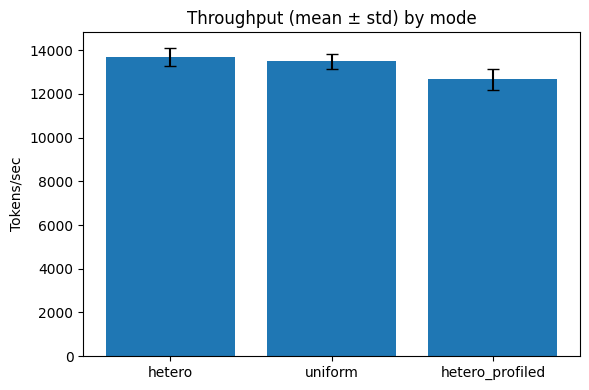

In [ ]:
import pandas as pd, matplotlib.pyplot as plt

summary = pd.read_csv("results/summary_stats.csv", index_col=0)
plt.figure(figsize=(6,4))
plt.bar(summary.index, summary["mean_tps"], yerr=summary["std_tps"], capsize=4)
plt.ylabel("Tokens/sec")
plt.title("Throughput (mean ± std) by mode")
plt.tight_layout()
plt.savefig("results/tps_mean_std.png", dpi=200)
print("Saved: results/tps_mean_std.png")
